<a href="https://colab.research.google.com/github/zekaouinoureddine/Advanced-transformer-based-models-on-opinion-mining/blob/master/notebooks/Movie_Reviews_XLNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<h1 align="center"><strong>Movie Reviews XLNet</strong></h1>

---

In [ ]:
!pip install SentencePiece -q
!pip install transformers -q

     |████████████████████████████████| 1.2 MB 8.2 MB/s 
     |████████████████████████████████| 4.0 MB 16.7 MB/s 
     |████████████████████████████████| 596 kB 49.1 MB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 
     |████████████████████████████████| 6.6 MB 24.2 MB/s 
     |████████████████████████████████| 77 kB 3.7 MB/s 


### Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn import metrics

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!gdown --id 1xJYm-tNMllxx82_CQ1K1R5q0JW9KUV1j -q
!unzip IMDb.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Archive:  IMDb.zip
  inflating: IMDB Dataset.csv        


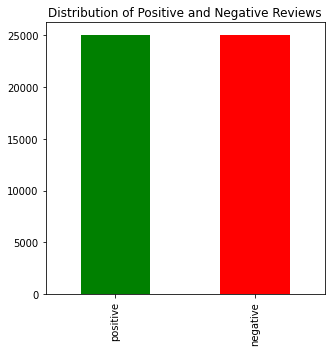

In [ ]:
df = pd.read_csv("IMDB Dataset.csv")

df["sentiment"].value_counts().plot(kind='bar',
                                    color=['green','red'],
                                    title='Distribution of Positive and Negative Reviews',
                                    figsize=(5,5));

### Config

In [ ]:
class Config:
  MAX_LEN = 384
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 4
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  XLNet_PATH = "xlnet-base-cased"
  MODEL_PATH = "xlnetModel.bin"
  TRAINING_DATA = "IMDB Dataset.csv"

  TOKENIZER = transformers.XLNetTokenizer.from_pretrained(XLNet_PATH, do_lower_case = True)
  MODEL = transformers.XLNetModel.from_pretrained(XLNet_PATH, return_dict=True)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Dataset

In [ ]:
class DataProcess:
  def __init__(self, review):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = review
    
  def preprocess_bert(self):
    reviw = " ".join(self.review.split())
    inputs = self.tokenizer.encode_plus(
        reviw,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0),
        torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]

class MovieReviewDatSet:
  def __init__(self, data_path):
    
    self.data = pd.read_csv(data_path).fillna('none')
    self.data.sentiment = self.data.sentiment.apply(lambda x: 1 if x == "positive" else 0)
    self.data = self.data.reset_index(drop=True)
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = self.data.review.values
    self.label = self.data.sentiment.values

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    review = " ".join(review.split())

    inputs = self.tokenizer.encode_plus(
        review,
        None,
        add_special_tokens = True,
        max_length = self.max_len,
        padding = "max_length",
        truncation= True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return {
        "input_ids" : torch.tensor(input_ids, dtype=torch.long),
        "attention_mask" : torch.tensor(attention_mask, dtype=torch.long),
        "token_type_ids" : torch.tensor(token_type_ids, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
        }

### Model

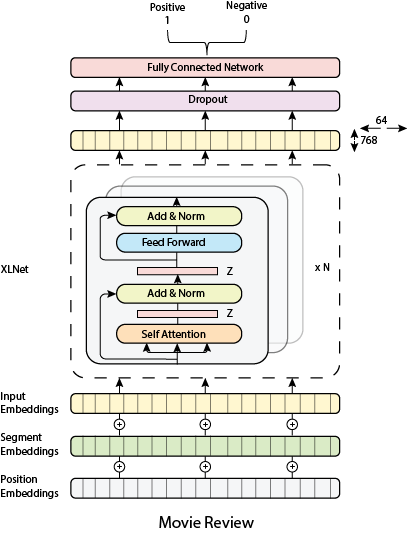

In [ ]:
class XLNetModel(nn.Module):
  def __init__(self):
    super(XLNetModel, self).__init__()
    self.bert = Config.MODEL
    # self.bert_drop = nn.Dropout(0.3)
    self.out = nn.Linear(768, 1)
    torch.nn.init.xavier_normal_(self.out.weight)

  def forward(self, input_ids, attention_mask, token_type_ids):
    last_hidden_state = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    # bo = self.bert_drop(pooled_output)
    mean_last_hidden_state = torch.mean(last_hidden_state[0], 1)
    output = self.out(mean_last_hidden_state)
    
    return output

### Engine

In [ ]:
def loss_fn(outputs, labels):
  return nn.BCEWithLogitsLoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    token_type_ids = d["token_type_ids"]
    labels = d["labels"]

    input_ids = input_ids.to(device, dtype=torch.long)
    attention_mask = attention_mask.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype = torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      token_type_ids = d["token_type_ids"]
      labels = d["labels"]

      input_ids = input_ids.to(device, dtype=torch.long)
      attention_mask = attention_mask.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype = torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### Train

In [ ]:
dataset = MovieReviewDatSet(Config.TRAINING_DATA)

train_data, valid_data = train_test_split(dataset, test_size = 0.1)
train_dataloader = DataLoader(train_data, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)
valid_dataloader = DataLoader(valid_data, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model = XLNetModel()
model.to(Config.DEVICE)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(train_data) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

history = defaultdict(list)

best_accuracy = 0
for epoch in range(1, Config.EPOCHS+1):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)
  
  train_outputs = np.array(train_outputs) >= 0.5
  valid_outputs = np.array(valid_outputs) >= 0.5

  train_accuracy = metrics.accuracy_score(train_labels, train_outputs)
  valid_accuracy = metrics.accuracy_score(valid_labels, valid_outputs)

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train Accuracy: {train_accuracy} \nValid Loss: {valid_loss} - Valid Accuracy: {valid_accuracy}\n")
  
  history['Train Loss'].append(train_loss)
  history['Train Accuracy'].append(train_accuracy)
  history['Valid Loss'].append(valid_loss)
  history['Valid Accuracy'].append(valid_accuracy)
  
  if valid_accuracy > best_accuracy:
    torch.save(model.state_dict(), Config.MODEL_PATH)
    best_accuracy = valid_accuracy

100%|██████████| 1250/1250 [01:44<00:00, 12.01it/s]


Epoch: 1
Train Loss: 0.20420193323122546 - Train Accuracy: 0.9206888888888889 
Valid Loss: 0.19115103907270822 - Valid Accuracy: 0.9308



100%|██████████| 1250/1250 [01:41<00:00, 12.26it/s]


Epoch: 2
Train Loss: 0.10709203671242835 - Train Accuracy: 0.9629333333333333 
Valid Loss: 0.20496918699855451 - Valid Accuracy: 0.9346



100%|██████████| 1250/1250 [01:42<00:00, 12.21it/s]


Epoch: 3
Train Loss: 0.04799656426572603 - Train Accuracy: 0.9847111111111111 
Valid Loss: 0.19236454621949234 - Valid Accuracy: 0.9468



100%|██████████| 1250/1250 [01:45<00:00, 11.85it/s]


Epoch: 4
Train Loss: 0.020365430095631423 - Train Accuracy: 0.9942888888888889 
Valid Loss: 0.21369077028080646 - Valid Accuracy: 0.9482



### Error Analysis & Performance auditing

In [ ]:
def get_metrics(labels, outputs):
  accuracy = metrics.accuracy_score(labels, outputs)
  recall = metrics.recall_score(labels, outputs)
  precision = metrics.precision_score(labels, outputs)
  f1 = metrics.f1_score(labels, outputs)
  return accuracy, recall, precision, f1


Results summary

Accuracy Score  : 0.9482
Recall Score    : 0.9472037543996872
Precision Score : 0.9512961508248232
F1 Score        : 0.9492455418381344

Classification report 

               precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      2443
         1.0       0.95      0.95      0.95      2557

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



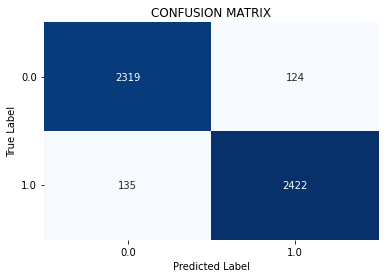

In [ ]:
accuracy, recall, precision, f1 = get_metrics(valid_labels, valid_outputs)

print("==="*50)
print("\nResults summary\n")
print(f"Accuracy Score  : {accuracy}")
print(f"Recall Score    : {recall}")
print(f"Precision Score : {precision}")
print(f"F1 Score        : {f1}")

print("==="*50)
print("\nClassification report \n\n", metrics.classification_report(valid_labels, valid_outputs))

print("==="*50)
cm = metrics.confusion_matrix(valid_labels, valid_outputs)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Label", 
       ylabel="True Label", 
       xticklabels=np.unique(valid_labels), 
       yticklabels=np.unique(valid_labels), 
       title="CONFUSION MATRIX")
plt.yticks(rotation=0);

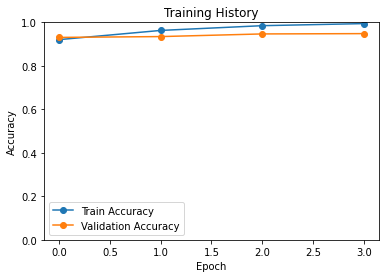

In [ ]:
plt.plot(history['Train Accuracy'], '-o', label='Train Accuracy')
plt.plot(history['Valid Accuracy'], '-o', label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

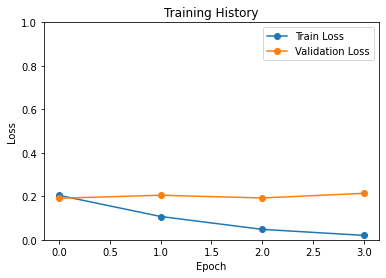

In [ ]:
plt.plot(history['Train Loss'], '-o', label='Train Loss')
plt.plot(history['Valid Loss'], '-o', label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference

In [ ]:
model = XLNetModel()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(review: str):
  data = DataProcess(review)
  input_ids, attention_mask, token_type_ids = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  token_type_ids = token_type_ids.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model(input_ids, attention_mask, token_type_ids) 
  positive_prediction = data.preprocess_output(outputs)
  negative_prediction = 1 - positive_prediction
  
  return {
      "review": review,
      "positive": str(positive_prediction),
      "negative": str(negative_prediction),
  }

In [ ]:
sentiment = predict("I like this amazing movie")
print(sentiment)

{'review': 'I like this amazing movie', 'positive': '0.9637947', 'negative': '0.036205291748046875'}


### References:
* **Zhilin Yang, Zihang Dai, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, Quoc V. Le. 2019. [XLNet: Generalized Autoregressive Pretraining for Language Understanding](https://arxiv.org/abs/1906.08237). arXiv preprint arXiv:1906.08237.**